<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Module 2
:</span> Base Table Construction</h1>


<br><hr id="toci">

### Build data ...

1. [Drop unwanted observations](#drop)
2. [Handle missing data](#missing-data)
3. [Engineer features](#engineer-features)
4. [Save the ABT](#save-abt)
5. [Model training](#training)

<br>
#### The focus for building the model is to have a good enough model to demonstrate how to use python Dash server to allow users a possbile method to use the model to get predictions and take informed decisions and hence interpretation of the model training and test results has not been done rigorously
<br><hr>

In [4]:
# NumPy for numerical computing
import numpy as np
# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
import matplotlib.pyplot as plt
# display plots in the notebook
%matplotlib inline
# Seaborn for easier visualization
import seaborn as sns

In [5]:
data = pd.read_csv('HR_comma_sep.csv')

In [6]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<span id="drop"></span>
## Data preprocessing

In [7]:
# drop unwanted observations
print(data.shape)
data.drop_duplicates()
print(data.shape)

(14999, 10)
(14999, 10)


In [8]:
# Unique classes of 'department'
data.Department.unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [9]:
# Print unique values of 'filed_complaint'
print(data.Work_accident.unique())
# Print unique values of 'recently_promoted'
print(data.promotion_last_5years.unique())
# Print unique values of 'left'
print(data.left.unique())

[0 1]
[0 1]
[1 0]


<span id="missing-data"></span>
## Handle missing data

In [10]:
# check for missing values
data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

The data features has no missing values

<span id="engineer-features"></span>

## Engineer features

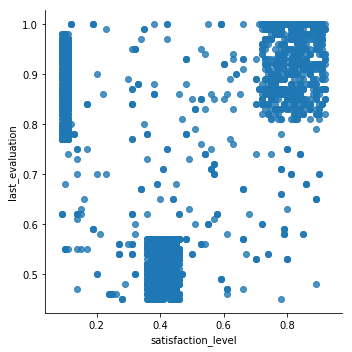

In [11]:
sns.lmplot(y='last_evaluation', x='satisfaction_level', data=data[data['left']==1], fit_reg=False)

These roughly translate to 3 **indicator features** we can engineer:

* <code style="color:steelblue">'underperformer'</code> - last_evaluation < 0.6
* <code style="color:steelblue">'unhappy'</code> - satisfaction_level < 0.2
* <code style="color:steelblue">'overachiever'</code> - last_evaluation > 0.8 and satisfaction > 0.7

In [12]:
# Create indicator features
data['underperformer'] = (data.last_evaluation < 0.6).astype(int)
data['unhappy'] = (data.satisfaction_level < 0.2).astype(int)
data['overachiever'] = ((data.last_evaluation > 0.8) & (data.satisfaction_level > 0.7)).astype(int)

In [13]:
# The proportion of observations belonging to each group
data[['underperformer', 'unhappy', 'overachiever']].mean()

underperformer    0.316154
unhappy           0.093940
overachiever      0.186212
dtype: float64

<span id="save-abt"></span>
## Base Table


In [14]:
# The proportion of observations who 'Left'
sum(data.left)/len(data)

0.2380825388359224

In [15]:
# Create new dataframe with dummy features
cate_columns = data.select_dtypes(include=['object']).columns
btable = pd.get_dummies(data, columns=cate_columns)
# Display first 10 rows
pd.set_option('display.max_columns', 50)
btable.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,underperformer,unhappy,overachiever,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


<hr>
<span style="font-size:20px;text-align:center">[Back to Contents](#toci)</span>

## Model Training
<span id=training><span>

In [16]:
# Pickle for saving model files
import pickle

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Function for splitting training and test set
from sklearn.model_selection import train_test_split
# Function for creating model pipelines
from sklearn.pipeline import make_pipeline
# For standardization
from sklearn.preprocessing import StandardScaler
# Helper for cross-validation
from sklearn.model_selection import GridSearchCV
# Classification metrics (added later)
from sklearn.metrics import roc_curve, auc

#### Split the data

In [17]:
# Create separate object for target variable
y = btable.left

# Create separate object for input features
X = btable.drop('left', axis=1)

In [18]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= 0.2,
                                                    random_state=1234,
                                                    stratify=btable.left)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

11999 3000 11999 3000


In [19]:
print(btable.average_montly_hours.min())
print(btable.average_montly_hours.max())
print(310-96)

96
310
214


In [20]:
# min_max scalar
def scaler(x):
    return round((x-96)/214,2)

<span id="pipelines"></span>
## Build model pipelines

In [21]:
pipeline = make_pipeline(RandomForestClassifier(random_state=123))

Scaling has not been done to keep the model simple, since predictions are done for single input observation. But scaling is required for making a model which can give credible predictions

In [22]:
# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}

<span id="fit-tune"></span>
### Fit and tune models with cross-validation

In [23]:
model = GridSearchCV(pipeline, rf_hyperparameters, cv=10, n_jobs=-1)

model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'randomforestclassifier__n_estimators': [100, 200], 'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
# model best score
model.best_score_

0.99149929160763395

<span id="evaluate"></span>
## Evaluate metrics

In [25]:
# Classification metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [26]:
pred = model.predict(X_test)

In [27]:
print(confusion_matrix(y_test, pred))

[[2283    3]
 [  18  696]]


In [28]:
pred_prob = model.predict_proba(X_test)

pred_prob = [p[1] for p in pred_prob]

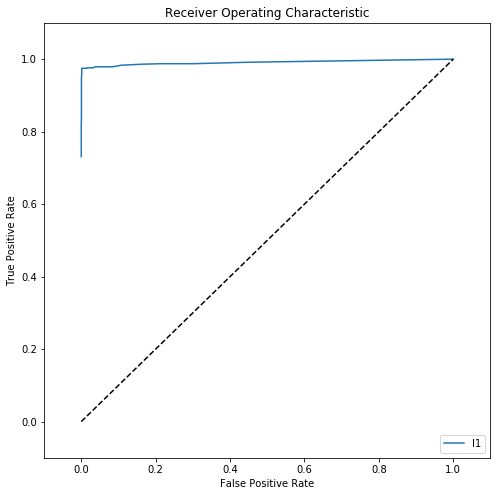

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

# Initialize figure
plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
# Calculate AUROC
print(auc(fpr, tpr))

0.991072194407


In [31]:
# Save winning model as final_model.pkl
with open('final_model.pkl', 'wb') as f:
    pickle.dump(model.best_estimator_, f)

#### Reading the pickle file to get the stored model to perform predictions and calculate auc

In [69]:
objects = []
with open('final_model.pkl', 'rb') as f:
    objects.append(pickle.load(f))

In [70]:
pred = objects[0].predict_proba(X_test)
pred = [p[1] for p in pred]

fpr, tpr, threshold = roc_curve(y_test, pred)
print(auc(fpr, tpr)) 

0.991072194407


The score matches the previous AUROC score, the model was saved into pickle file correctly and can be used for making predictions